<img src="logo_ue.png" width="400"/>


# ANEXO 3
# 3. DESARROLLO DEL PROYECTO
## 3.3 Representación vectorial de los textos
## TF-IDF y Similitud del Coseno

In [3]:
from tqdm import tqdm
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [4]:
df_iniciativas = pd.read_excel("fuentes_informacion\IniciativasPDET_preprocesadas.xlsx")
df_proyectos = pd.read_excel("fuentes_informacion\ProyectosInversion_preprocesados.xlsx")

## Desnormalizar proyectos e iniciativas por municipio

In [5]:

df_iniciativas['codigosdane'] = df_iniciativas['codigosdane'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
)

df_proyectos['codigoentidadnormalizado'] = df_proyectos['codigoentidadnormalizado'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
)

# Expandir cada fila por código DANE individual
df_iniciativas_exp = df_iniciativas.explode('codigosdane').copy()
df_proyectos_exp = df_proyectos.explode('codigoentidadnormalizado').copy()

# Renombrar para unificar
df_iniciativas_exp.rename(columns={'codigosdane': 'codigo_dane'}, inplace=True)
df_proyectos_exp.rename(columns={'codigoentidadnormalizado': 'codigo_dane'}, inplace=True)

# Asegurar formato uniforme
df_iniciativas_exp['codigo_dane'] = df_iniciativas_exp['codigo_dane'].astype(str).str.zfill(5)
df_proyectos_exp['codigo_dane'] = df_proyectos_exp['codigo_dane'].astype(str).str.zfill(5)

# Filtrar municipios que existan en ambos conjuntos
codigos_comunes = set(df_iniciativas_exp['codigo_dane']) & set(df_proyectos_exp['codigo_dane'])
df_iniciativas_exp = df_iniciativas_exp[df_iniciativas_exp['codigo_dane'].isin(codigos_comunes)].copy()
df_proyectos_exp = df_proyectos_exp[df_proyectos_exp['codigo_dane'].isin(codigos_comunes)].copy()

# Confirmar
print(f"✅ Municipios comunes encontrados: {len(codigos_comunes)}")
print(f"📌 Iniciativas vinculadas territorialmente: {len(df_iniciativas_exp)}")
print(f"📌 Proyectos vinculados territorialmente: {len(df_proyectos_exp)}")


✅ Municipios comunes encontrados: 170
📌 Iniciativas vinculadas territorialmente: 51750
📌 Proyectos vinculados territorialmente: 158230


## Visualizar resultados

In [6]:

muestra_3 = df_iniciativas_exp[['código_iniciativa', 'codigo_dane', 'texto_preprocesado']].drop_duplicates().head(3)

ejemplos = []

for _, row in muestra_3.iterrows():
    proyectos_match = df_proyectos_exp[df_proyectos_exp['codigo_dane'] == row['codigo_dane']]
    for _, p in proyectos_match.iterrows():
       ejemplos.append({
            'codigo_dane': row['codigo_dane'],
            'código_iniciativa': row['código_iniciativa'],
            'texto_iniciativa': row['texto_preprocesado'],
            'bpin': p['bpin'],
            'texto_proyecto': p['texto_preprocesado']
        })

df_ejemplo_vinculacion = pd.DataFrame(ejemplos)

# Truncar los textos a los primeros 100 caracteres
df_ejemplo_vinculacion['texto_iniciativa'] = df_ejemplo_vinculacion['texto_iniciativa'].str[:100]+'...'
df_ejemplo_vinculacion['texto_proyecto'] = df_ejemplo_vinculacion['texto_proyecto'].str[:100]+'...'

# Mostrar
pd.set_option('display.max_colwidth', None)
display(df_ejemplo_vinculacion.head(5))

,codigo_dane,código_iniciativa,texto_iniciativa,bpin,texto_proyecto
0,54670,454670190137,adecuar optimizar infraestructura existente acueducto_veredal zona_rural caserio centro_poblado abas...,2021004540147,apoyo fortalecer_gobernabilidad gestion_riesgo desastre departamento norte_santander gestion_riesgo ...
1,54670,454670190137,adecuar optimizar infraestructura existente acueducto_veredal zona_rural caserio centro_poblado abas...,2019004540143,desarrollo fase_departamental juegos_deportivo nacional magisterio encuentro_folclorico cultural nor...
2,54670,454670190137,adecuar optimizar infraestructura existente acueducto_veredal zona_rural caserio centro_poblado abas...,2021004540036,apoyo mejoramiento conocimiento riesgo_desastre norte_santander alternativa aumentar conocimiento ri...
3,54670,454670190137,adecuar optimizar infraestructura existente acueducto_veredal zona_rural caserio centro_poblado abas...,2017004540024,fortalecimiento centro rehabilitacion_cardioneuromuscular cucutir actividad comprender fortalecimien...
4,54670,454670190137,adecuar optimizar infraestructura existente acueducto_veredal zona_rural caserio centro_poblado abas...,2021004540153,desarrollo accion mitigacion_adaptacion cambio_climatico departamento norte_santander norte_santande...


## Calcular similitud

In [7]:
#for codigo_dane in tqdm(df_iniciativas_exp['codigo_dane'].unique()[:10], desc="Procesando 10 municipios"):
resultados_unicos = {}
umbral_similitud = 0  

# Proceso por todos los municipios
for codigo_dane in tqdm(df_iniciativas_exp['codigo_dane'].unique(), desc="Procesando municipios"):
    iniciativas = df_iniciativas_exp[df_iniciativas_exp['codigo_dane'] == codigo_dane]
    proyectos = df_proyectos_exp[df_proyectos_exp['codigo_dane'] == codigo_dane]

    if iniciativas.empty or proyectos.empty:
        continue

    textos = list(iniciativas['texto_preprocesado']) + list(proyectos['texto_preprocesado'])

    vectorizer = TfidfVectorizer()
    matriz_tfidf = vectorizer.fit_transform(textos)

    iniciativas_vecs = matriz_tfidf[:len(iniciativas)]
    proyectos_vecs = matriz_tfidf[len(iniciativas):]

    sim_matrix = cosine_similarity(iniciativas_vecs, proyectos_vecs)

    # ✅ Este bloque debe estar DENTRO del for por municipio
    for i, idx_i in enumerate(iniciativas.index):
        for j, idx_p in enumerate(proyectos.index):
            similitud = sim_matrix[i, j]
            if similitud >= umbral_similitud:  
                cod_ini = df_iniciativas.loc[idx_i, 'código_iniciativa']
                cod_proj = df_proyectos.loc[idx_p, 'bpin']
                clave = (cod_ini, cod_proj)
                if clave not in resultados_unicos or similitud > resultados_unicos[clave]['similitud_coseno']:
                    resultados_unicos[clave] = {
                        'código_iniciativa': cod_ini,
                        'bpin': cod_proj,
                        'similitud_coseno': similitud
                    }

# Convertir a DataFrame
df_similitud_unica = pd.DataFrame(resultados_unicos.values())

Procesando municipios:   0%|          | 0/170 [00:00<?, ?it/s]

Procesando municipios: 100%|██████████| 170/170 [20:22<00:00,  7.19s/it]


## Visualizar resultados

In [8]:
# Extraer top 3 y unir textos
top_3 = df_similitud_unica.sort_values(by="similitud_coseno", ascending=False).head(3)

top_3 = top_3.merge(df_iniciativas[["código_iniciativa", "texto_preprocesado"]],
                      left_on="código_iniciativa", right_on="código_iniciativa", how="left") \
               .merge(df_proyectos[["bpin", "texto_preprocesado"]],
                      on="bpin", how="left", suffixes=("_iniciativa", "_proyecto"))

top_3 = top_3[["código_iniciativa", "bpin", "similitud_coseno",
                 "texto_preprocesado_iniciativa", "texto_preprocesado_proyecto"]]

top_3.rename(columns={
    "código_iniciativa": "Código Iniciativa",
    "bpin": "BPIN Proyecto",
    "similitud_coseno": "Similitud Coseno",
    "texto_preprocesado_iniciativa": "Texto Iniciativa",
    "texto_preprocesado_proyecto": "Texto Proyecto"
}, inplace=True)

pd.set_option('display.max_colwidth', None)
display(top_3)

,Código Iniciativa,BPIN Proyecto,Similitud Coseno,Texto Iniciativa,Texto Proyecto
0,1186865216639,2020868650192,0.848403,construir_alcantarilla vereda_nucleo municipio valle_guamuez departamento_putumayo construir_alcantarilla requerida vereda_nucleo municipio valle_guamuez departamento_putumayo donir vinculir siguiente obra descrito nucleo_cairo unidad construccion_alcantarilla hormiga cairo unidad cairo_delicia unidad recrear campo_hermoso unidad campo_hermoso yarinal unidad campo_hermoso palma unidad bellavista_triunfo unidad nucleo_placer unidad construccion_alcantarilla placer_angel unidad sar_isidro costa_rico unidad esmeralda mundo unidad mundo alto_guisia unidad alto_guisia arenoso unidad placer esmeraldar miravallir unidad casco_urbano inspeccion_placer unidad nucleo_miravalle rosal unidad construccion_alcantarilla santa_teresa hormiga frontera unidad hormiguir laurel unidad alto_guisia laurel unidad laurel betanio unidad sar_marcos guadual placer unidad guadual oasis unidad miravallir guadual unidad alto_palmira guadual unidad laurel alto_guisia unidad esmeralda_laurel unidad miravallir laurel unidad alto_palmira zarzal unidad providencia miravallir unidad providenciar zarzal unidad miravalle esmeraldar unidad santo_teresa pradera unidad sector poblado vereda santa_teresa unidad santo_teresa alto_palmira unidad santo_teresa cabildo_awa unidad nucleo jordan_guisia unidad construccion_alcantarilla inspeccion jordan_guisia unidad_jordar guisia_costenitar unidad limoncito unidad olivo unidad aji unidad llano puerto bellir unidad_jordar guisia temblon unidad temblon cartagena unidad arenoso temblon unidad_jordar guisia_comboy unidad betania jordar_guisia unidad betania_arenoso alto_guisia unidad nucleo_loro unidad construccion_alcantarilla via principal agua_blanco unidad via principal unidad florida san_fernando unidad primaverar unidad nucleo tigre unidad construccion_alcantarilla sector urbano tigre unidad raya campo_bello unidad raya bellavista unidad concordia primavera unidad raya pomos unidad concordia san_antonio unidad nucleo_maravelez unidad construccion_alcantarilla tigre rosario villa_arboleda unidad villa_hermoso jardin_selva unidad villa_hermoso brisa_guamuez unidad maravelez_pava unidad paraiso campo_bello unidad campo_bello chorroza unidad nucleo guadualito unidad construccion_alcantarilla mogambo_diamante unidad putumayo herradura_malvina italia unidad guadualito_esperanza unidad nucleo venado unidad box construccion_alcantarilla pava_bajo venado unidad box_coulvert chorroza venado unidad box_coulvert villanueir afilador unidad box_coulvert venado pomos triunfo union unidad box_coulvert san_jose sultana unidad retiro venado unidad venado_llano verde unidad,fortalecimiento pequeno emprendimiento marco implementacion posconflicto municipio valle_guamuez suministro emprendedor comprender vegetal litro kg_kg unidad kg unidad unidad cubierto unidad cm unidad unidad unidad unidad unidad unidad puesto unidad liquido litro barra_barra polvo paquete unidad exfoliante unidad unidad unidad unidad unidad unidad unidad conos unidad papel regalo pliego sedar pliego permanente unidad unidad regalo unidad fortalecer proceso emprendimiento desarrollo_economico empresarial victima_conflicto armado municipio
1,305107298309,2021051070057,0.788412,implementar acceso beca_estimulo subsidio_credito educacion tecnico_tecnologico profesional manutencion comunidad rural poblacion_victima municipio_briceno departamento_antioquia implementar acceso beca_estimulo subsidio_credito educacion tecnico_tecnologico profesional manutencion comunidad rural poblacion_victima permitir acceso calidad educativo pertinente eficaz municipio_briceno departamento_antioquia,implementacion acceso beca_estimulo subsidio_credito educacion tecnico_tecnologico profesional manutencion comunidad rural poblacion_victima municipio_briceno asd fgh
2,119256284295,20211301011844,0.750548,estudio_diseno construccion_dotacion centro atencion_integral adulto person

##  Histograma de distribución de similitudes


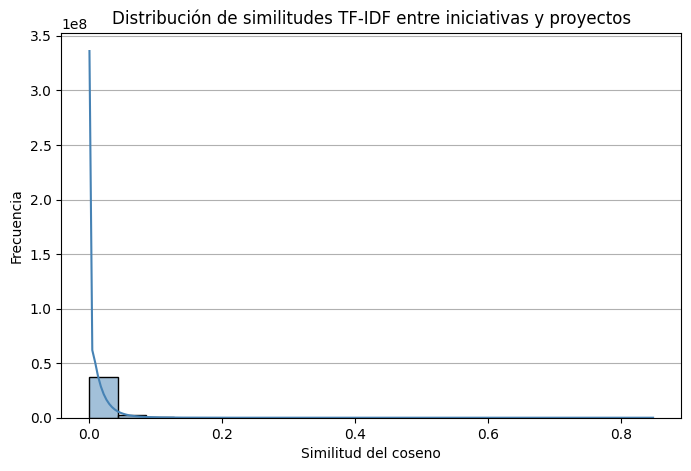

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(df_similitud_unica['similitud_coseno'], bins=20, kde=True, color='steelblue')
plt.title("Distribución de similitudes TF-IDF entre iniciativas y proyectos")
plt.xlabel("Similitud del coseno")
plt.ylabel("Frecuencia")
plt.grid(axis='y')
plt.show()

## Relación entre longitud del texto y similitud máxima (por iniciativa)

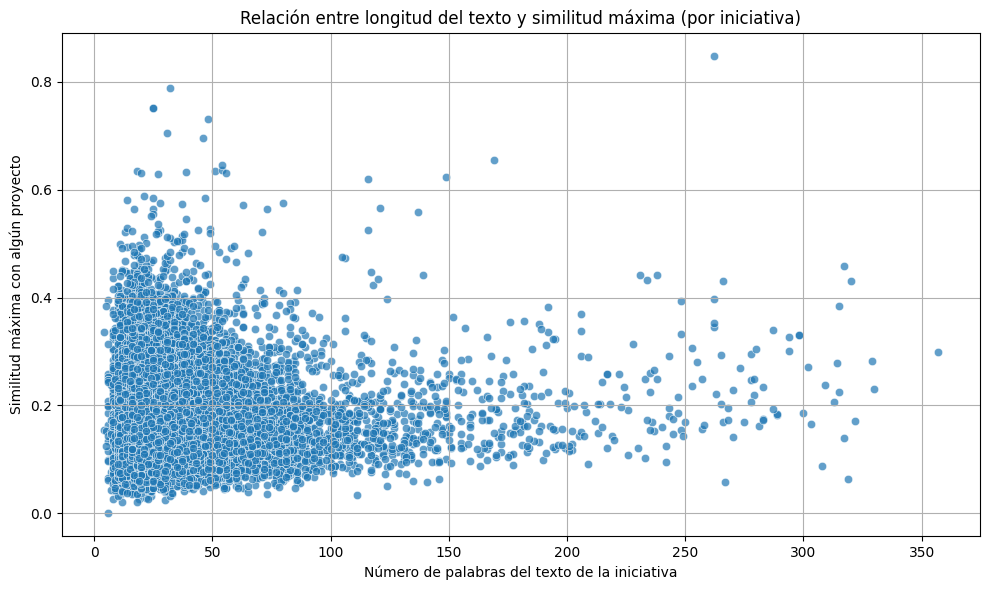

In [10]:
# Calcular longitud del texto de cada iniciativa
df_iniciativas['longitud_texto'] = df_iniciativas['texto_preprocesado'].astype(str).apply(lambda x: len(x.split()))

# Obtener la similitud máxima por iniciativa
df_max_sim = df_similitud_unica.groupby('código_iniciativa')['similitud_coseno'].max().reset_index()
df_max_sim = df_max_sim.merge(df_iniciativas[['código_iniciativa', 'longitud_texto']], on='código_iniciativa', how='left')

# Graficar
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_max_sim, x='longitud_texto', y='similitud_coseno', alpha=0.7)
plt.title("Relación entre longitud del texto y similitud máxima (por iniciativa)")
plt.xlabel("Número de palabras del texto de la iniciativa")
plt.ylabel("Similitud máxima con algún proyecto")
plt.grid(True)
plt.tight_layout()
plt.show()


## Visualización ejemplo

In [11]:
fila_similitud = df_similitud_unica[(df_similitud_unica["código_iniciativa"] == 1186865216639) &(df_similitud_unica["bpin"] == 2020868650192)]
texto_iniciativa = df_iniciativas.loc[df_iniciativas["código_iniciativa"] == 1186865216639, "texto_preprocesado"].values[0]
texto_proyecto = df_proyectos.loc[df_proyectos["bpin"] == 2020868650192, "texto_preprocesado"].values[0]
similitud = fila_similitud["similitud_coseno"].values[0]

# Construir tabla resumen
tabla_resultado = pd.DataFrame([{
    "código_iniciativa": 1186865216639,
    "iniciativa": texto_iniciativa,
    "bpin": 2020868650192,
    "proyecto": texto_proyecto,
    "similitud_coseno": round(similitud, 4)
}])

pd.set_option('display.max_colwidth', None)
display(tabla_resultado)


,código_iniciativa,iniciativa,bpin,proyecto,similitud_coseno
0,1186865216639,construir_alcantarilla vereda_nucleo municipio valle_guamuez departamento_putumayo construir_alcantarilla requerida vereda_nucleo municipio valle_guamuez departamento_putumayo donir vinculir siguiente obra descrito nucleo_cairo unidad construccion_alcantarilla hormiga cairo unidad cairo_delicia unidad recrear campo_hermoso unidad campo_hermoso yarinal unidad campo_hermoso palma unidad bellavista_triunfo unidad nucleo_placer unidad construccion_alcantarilla placer_angel unidad sar_isidro costa_rico unidad esmeralda mundo unidad mundo alto_guisia unidad alto_guisia arenoso unidad placer esmeraldar miravallir unidad casco_urbano inspeccion_placer unidad nucleo_miravalle rosal unidad construccion_alcantarilla santa_teresa hormiga frontera unidad hormiguir laurel unidad alto_guisia laurel unidad laurel betanio unidad sar_marcos guadual placer unidad guadual oasis unidad miravallir guadual unidad alto_palmira guadual unidad laurel alto_guisia unidad esmeralda_laurel unidad miravallir laurel unidad alto_palmira zarzal unidad providencia miravallir unidad providenciar zarzal unidad miravalle esmeraldar unidad santo_teresa pradera unidad sector poblado vereda santa_teresa unidad santo_teresa alto_palmira unidad santo_teresa cabildo_awa unidad nucleo jordan_guisia unidad construccion_alcantarilla inspeccion jordan_guisia unidad_jordar guisia_costenitar unidad limoncito unidad olivo unidad aji unidad llano puerto bellir unidad_jordar guisia temblon unidad temblon cartagena unidad arenoso temblon unidad_jordar guisia_comboy unidad betania jordar_guisia unidad betania_arenoso alto_guisia unidad nucleo_loro unidad construccion_alcantarilla via principal agua_blanco unidad via principal unidad florida san_fernando unidad primaverar unidad nucleo tigre unidad construccion_alcantarilla sector urbano tigre unidad raya campo_bello unidad raya bellavista unidad concordia primavera unidad raya pomos unidad concordia san_antonio unidad nucleo_maravelez unidad construccion_alcantarilla tigre rosario villa_arboleda unidad villa_hermoso jardin_selva unidad villa_hermoso brisa_guamuez unidad maravelez_pava unidad paraiso campo_bello unidad campo_bello chorroza unidad nucleo guadualito unidad construccion_alcantarilla mogambo_diamante unidad putumayo herradura_malvina italia unidad guadualito_esperanza unidad nucleo venado unidad box construccion_alcantarilla pava_bajo venado unidad box_coulvert chorroza venado unidad box_coulvert villanueir afilador unidad box_coulvert venado pomos triunfo union unidad box_coulvert san_jose sultana unidad retiro venado unidad venado_llano verde unidad,2020868650192,fortalecimiento pequeno emprendimiento marco implementacion posconflicto municipio valle_guamuez suministro emprendedor comprender vegetal litro kg_kg unidad kg unidad unidad cubierto unidad cm unidad unidad unidad unidad unidad unidad puesto unidad liquido litro barra_barra polvo paquete unidad exfoliante unidad unidad unidad unidad unidad unidad unidad conos unidad papel regalo pliego sedar pliego permanente unidad unidad regalo unidad fortalecer proceso emprendimiento desarrollo_economico empresarial victima_conflicto armado municipio,0.8484
